# SPINN NF2 inputdata generation
> save using pickle

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "3"

In [ ]:
from zpinn.lowloumag import LowLouMag

In [ ]:
import json

In [ ]:
with open('config.json') as config:
    info = json.load(config)

nx = info['nx']
ny = info['ny']
nz = info['nz']
b_norm = info['b_norm']

In [ ]:
b = LowLouMag(resolutions=[nx, ny, nz])
b.calculate()

ImageData (0x7f42ed528ac0)
  N Cells:      16581375
  N Points:     16777216
  X Bounds:     -1.000e+00, 1.000e+00
  Y Bounds:     -1.000e+00, 1.000e+00
  Z Bounds:     0.000e+00, 2.000e+00
  Dimensions:   256, 256, 256
  Spacing:      7.843e-03, 7.843e-03, 7.843e-03
  N Arrays:     3

In [ ]:
import pickle

In [ ]:
with open("b.pickle","wb") as f:
    pickle.dump(b, f)

In [ ]:
with open("bv.pickle","wb") as f:
    pickle.dump(b.grid['B'], f)

In [ ]:
with open("b.pickle","rb") as f:
    b = pickle.load(f)

KeyboardInterrupt: 

In [ ]:
with open("bv.pickle","rb") as f:
    bv = pickle.load(f)

In [ ]:
b.bottom

PolyData (0x7fc07672d4e0)
  N Cells:    261121
  N Points:   262144
  N Strips:   0
  X Bounds:   -1.000e+00, 1.000e+00
  Y Bounds:   -1.000e+00, 1.000e+00
  Z Bounds:   0.000e+00, 0.000e+00
  N Arrays:   5

In [ ]:
b_bottom = b.b_bottom
b_bottom.shape

(256, 256, 3)

In [ ]:
b_bottom = b_bottom / b_norm 

In [ ]:
with open("b_bottom.pickle","wb") as f:
    pickle.dump(b_bottom, f)

In [ ]:
with open("b_bottom.pickle","rb") as f:
    b_bottom = pickle.load(f)

In [ ]:
import matplotlib.pyplot as plt

<matplotlib.image.AxesImage>

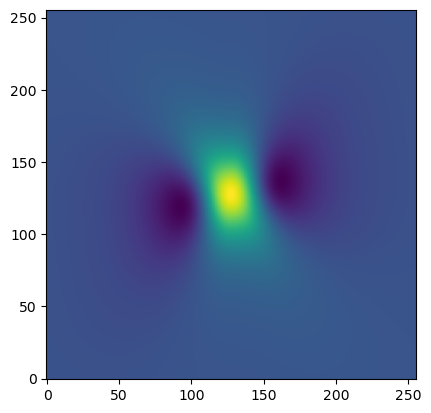

In [ ]:
plt.imshow(b_bottom[:, :, 2].transpose(), origin='lower')

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from tqdm import tqdm

/userhome/jeon_mg/mambaforge/envs/pinf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from zpinn.pinn_nf2_cleanup import PotentialModel, create_coordinates

In [ ]:
bottom_values = b_bottom.reshape(-1, 3)
bottom_bounds = (0, nx-1, 0, ny-1, 0, 0)
bottom_coords = create_coordinates(bottom_bounds).reshape(-1, 3)

In [ ]:
top_bounds = (0, nx-1, 0, ny-1, nz-1, nz-1)
lateral_bounds_1 = (0, 0, 0, ny-1, 0, nz-1)
lateral_bounds_2 = (nx-1, nx-1, 0, ny-1, 0, nz-1)
lateral_bounds_3 = (0, nx-1, 0, 0, 0, nz-1)
lateral_bounds_4 = (0, nx-1, ny-1, ny-1, 0, nz-1)

top_coords = create_coordinates(top_bounds)
lateral_coords_1 = create_coordinates(lateral_bounds_1)
lateral_coords_2 = create_coordinates(lateral_bounds_2)
lateral_coords_3 = create_coordinates(lateral_bounds_3)
lateral_coords_4 = create_coordinates(lateral_bounds_4)

In [ ]:
top_lateral_coordinates = [top_coords,
                           lateral_coords_1,
                           lateral_coords_2,
                           lateral_coords_3,
                           lateral_coords_4]

In [ ]:
def get_potential_boundary(b_n, height, batch_size=2048, **kwargs):
    assert not np.any(np.isnan(b_n)), 'Invalid data value'

    cube_shape = (*b_n.shape, height)

    b_n = b_n.reshape((-1)).astype(np.float32)
    coords = [np.stack(np.mgrid[:cube_shape[0], :cube_shape[1], cube_shape[2] - 2:cube_shape[2] + 1], -1),       #top
              np.stack(np.mgrid[:cube_shape[0], -1:2, :cube_shape[2]], -1),                                      #y=0
              np.stack(np.mgrid[:cube_shape[0], cube_shape[1] - 2:cube_shape[1] + 1, :cube_shape[2]], -1),       #y=max
              np.stack(np.mgrid[-1:2, :cube_shape[1], :cube_shape[2]], -1),                                      #x=0
              np.stack(np.mgrid[cube_shape[0] - 2:cube_shape[0] + 1, :cube_shape[1], :cube_shape[2]], -1), ]     #x=max
    fields = _compute_fields(coords, cube_shape, b_n, batch_size=batch_size, **kwargs)

    fields = [fields[0][:, :, 1],
              fields[1][:, 1, :], fields[2][:, 1, :],
              fields[3][1, :, :], fields[4][1, :, :]]
    coords = [coords[0][:, :, 1],
              coords[1][:, 1, :], coords[2][:, 1, :],
              coords[3][1, :, :], coords[4][1, :, :]]
    return coords, fields

def _compute_fields(coords, cube_shape, b_n, batch_size=2048, progress=False):
    coords_shape = [c.shape[:-1] for c in coords]
    flat_coords = np.concatenate([c.reshape(((-1, 3))) for c in coords])

    r_p = np.stack(np.mgrid[:cube_shape[0], :cube_shape[1], :1], -1).reshape((-1, 3))

    # torch code
    # r = (x * y, 3); coords = (x*y*z, 3), c = (1, 3)
    # --> (x * y, x * y * z, 3) --> (x * y, x * y * z) --> (x * y * z)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    with torch.no_grad():
        b_n = torch.tensor(b_n, dtype=torch.float32, )
        r_p = torch.tensor(r_p, dtype=torch.float32, )
        model = nn.DataParallel(PotentialModel(b_n, r_p, )).to(device)

        flat_coords = torch.tensor(flat_coords, dtype=torch.float32, )

        potential = []
        iter = DataLoader(TensorDataset(flat_coords), batch_size=batch_size, num_workers=2)
        iter = iter if progress else tqdm(iter, desc='Potential Field')
        for coord, in iter:
            coord = coord.to(device)
            p_batch = model(coord)
            potential += [p_batch.cpu()]

    potential = torch.cat(potential).numpy()
    idx = 0
    fields = []
    for s in coords_shape:
        p = potential[idx:idx + np.prod(s)].reshape(s)
        b = - 1 * np.stack(np.gradient(p, axis=[0, 1, 2], edge_order=2), axis=-1)
        fields += [b]
        idx += np.prod(s)

    return fields

In [ ]:
coords, fields = get_potential_boundary(b_bottom[:, :, 2], nz)

Potential Field: 100%|██████████| 480/480 [00:19<00:00, 24.79it/s]


In [ ]:
# bp_top = np.zeros((nx, ny, 3))
# bp_lateral_1 = np.zeros((ny, nz, 3))
# bp_lateral_2 = np.zeros((ny, nz, 3))
# bp_lateral_3 = np.zeros((nx, nz, 3))
# bp_lateral_4 = np.zeros((nx, nz, 3))

In [ ]:
bp_top = fields[0]
bp_lateral_3 = fields[1]
bp_lateral_4 = fields[2]
bp_lateral_1 = fields[3]
bp_lateral_2 = fields[4]

In [ ]:
bp_top = bp_top / b_norm
bp_lateral_1 = bp_lateral_1 / b_norm
bp_lateral_2 = bp_lateral_2 / b_norm
bp_lateral_3 = bp_lateral_3 / b_norm 
bp_lateral_4 = bp_lateral_4 / b_norm

In [ ]:
import pickle

In [ ]:


with open("bp_top.pickle","wb") as f:
    pickle.dump(bp_top, f)

with open("bp_lateral_1.pickle","wb") as f:
    pickle.dump(bp_lateral_1, f)

with open("bp_lateral_2.pickle","wb") as f:
    pickle.dump(bp_lateral_2, f)

with open("bp_lateral_3.pickle","wb") as f:
    pickle.dump(bp_lateral_3, f)

with open("bp_lateral_4.pickle","wb") as f:
    pickle.dump(bp_lateral_4, f)

In [ ]:
b.grid['B'].shape

(262144, 3)

In [ ]:
b_bottom.shape, bp_top.shape, bp_lateral_1.shape, bp_lateral_2.shape, bp_lateral_3.shape, bp_lateral_4.shape

((64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3))

In [ ]:
with open("bp_top.pickle","rb") as f:
    bp_top = pickle.load(f)

with open("bp_lateral_1.pickle","rb") as f:
    bp_lateral_1 = pickle.load(f)

with open("bp_lateral_2.pickle","rb") as f:
    bp_lateral_2 = pickle.load(f)

with open("bp_lateral_3.pickle","rb") as f:
    bp_lateral_3 = pickle.load(f)

with open("bp_lateral_4.pickle","rb") as f:
    bp_lateral_4 = pickle.load(f)

In [ ]:
bv.shape

(262144, 3)

In [ ]:
b_bottom.shape, bp_top.shape, bp_lateral_1.shape, bp_lateral_2.shape, bp_lateral_3.shape, bp_lateral_4.shape

((64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3))